# SPACEc: ML-enabled cell type annotation (SVM)

After preprocessing the single-cell data, the next step is to assign cell types. SPACEc utilizes the linear SVM model to train and classify to annotate cell types if training data is available.

In [8]:
# import spacec first
import spacec as sp

#import standard packages
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
# Specify the path to the data
root_path = "/home/user/path/SPACEc/" # inset your own path
data_path = root_path + 'example_data/raw/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'example_data/output/'
os.makedirs(output_dir, exist_ok=True)

## Data Explanation
Annotated tonsil data is used as training & test data. </br>
Tonsillitis data is used as validation data.

In [7]:
# Load training data
adata = sc.read(output_dir + "adata_nn_demo_annotated.h5ad")
adata_train = adata[adata.obs['condition'] == 'tonsil']
adata_val  = adata[adata.obs['condition'] == 'tonsillitis']

## Training

In [9]:
# Check if there are any NaN values in the data
np.isnan(adata_train.X).sum()

0

['B cell', 'CD4+ T cell', 'CD8+ T cell', 'DC', 'Epithelial cell', ..., 'NK cell', 'Plasma cell', 'Treg', 'Vessel', 'cDC1']
Length: 14
Categories (14, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'DC', ..., 'Plasma cell', 'Treg', 'Vessel', 'cDC1']
Training now!
Evaluating now!


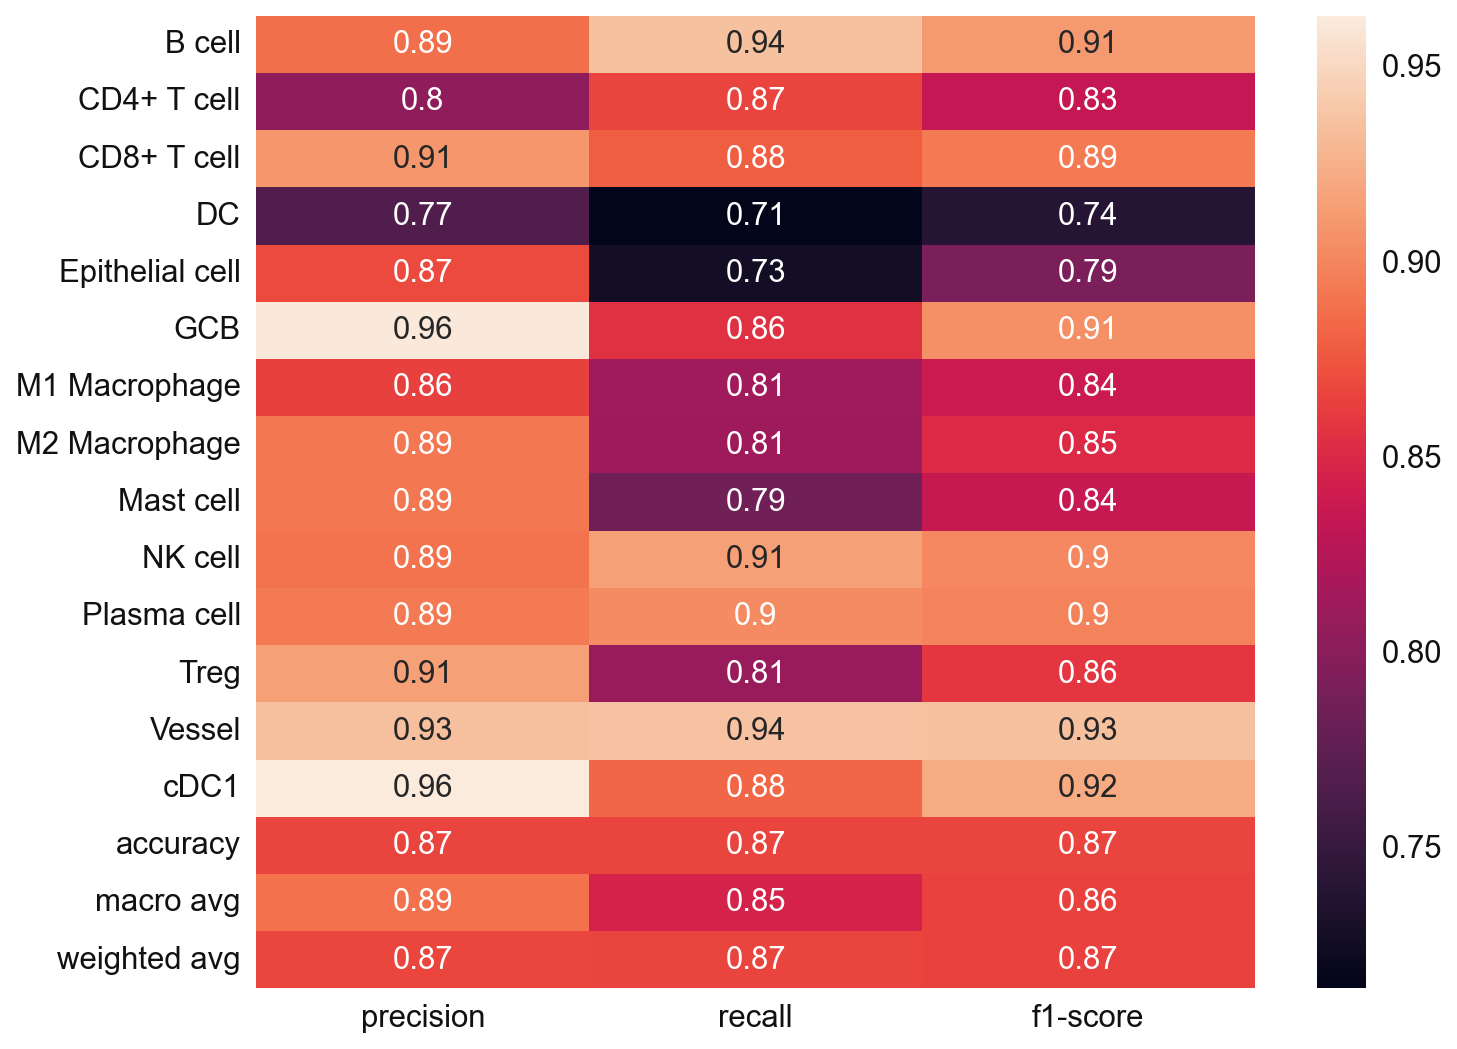

In [20]:
# Train a SVM model
svc = sp.tl.ml_train(
    adata_train=adata_train,
    label='cell_type',
    nan_policy_y='omit')

In [21]:
sp.tl.ml_predict(
    adata_val = adata_val,
    svc = svc,
    save_name = "svm_pred")

Classifying!
Saving cell type labels to adata!


... storing 'svm_pred' as categorical


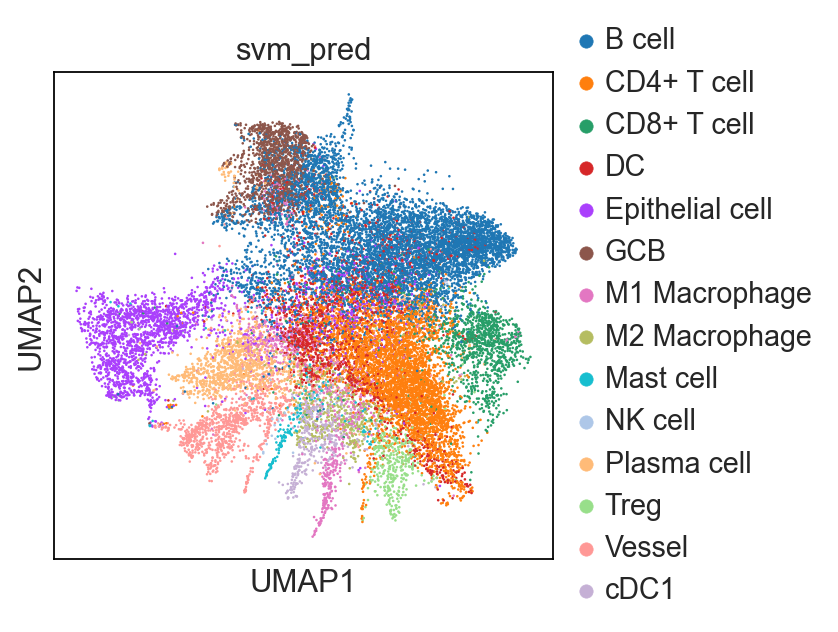

In [22]:
sc.pl.umap(adata_val, color = 'svm_pred')

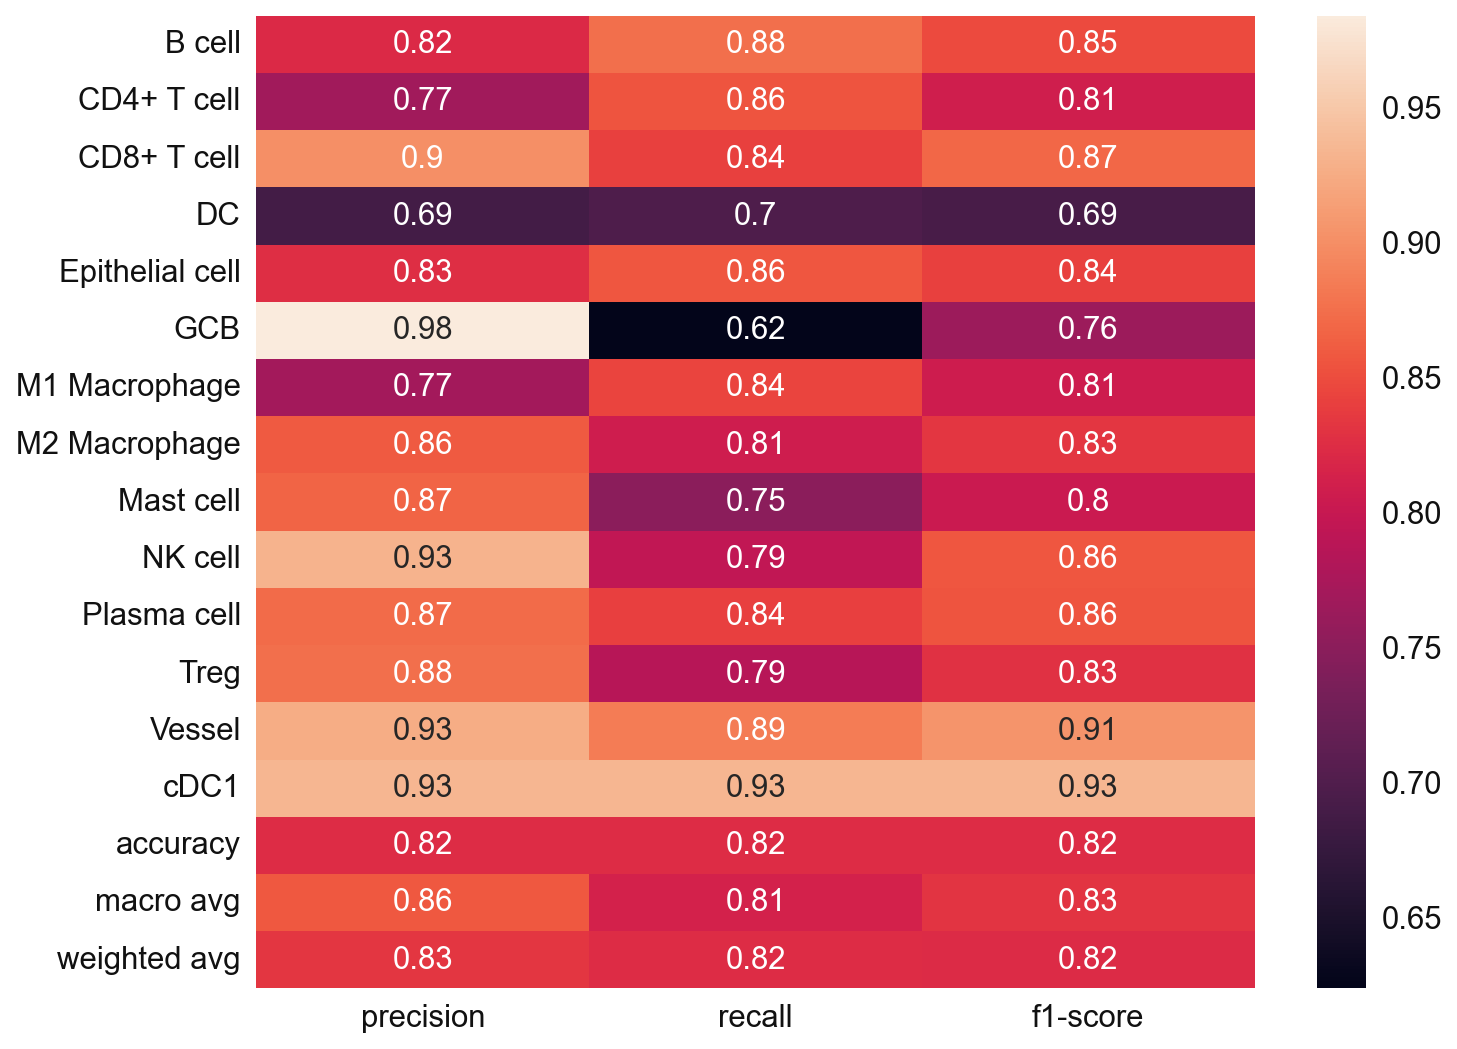

In [23]:
# Since we also know the cell type annotation of the adata_val, we can check in this case
from sklearn.metrics import classification_report

y_true = adata_val.obs['cell_type'].values
y_pred = adata_val.obs['svm_pred'].values
nan_mask = ~y_true.isna()
y_true = y_true[nan_mask]
y_pred = y_pred[nan_mask]

svm_eval = classification_report(
    y_true = y_true, 
    y_pred = y_pred, 
    target_names=svc.classes_, 
    output_dict=True)

plt.figure(figsize=(10, 8))

sns.heatmap(
    pd.DataFrame(svm_eval).iloc[:-1, :].T, 
    annot=True)
plt.show()

In [24]:
import pickle
filename = 'svc_model.sav'
pickle.dump(svc, open(output_dir + filename, 'wb'))
#adata_val.write(output_dir + "adata_nn_ml_demo_annotated.h5ad")

## Single-cell visualzation

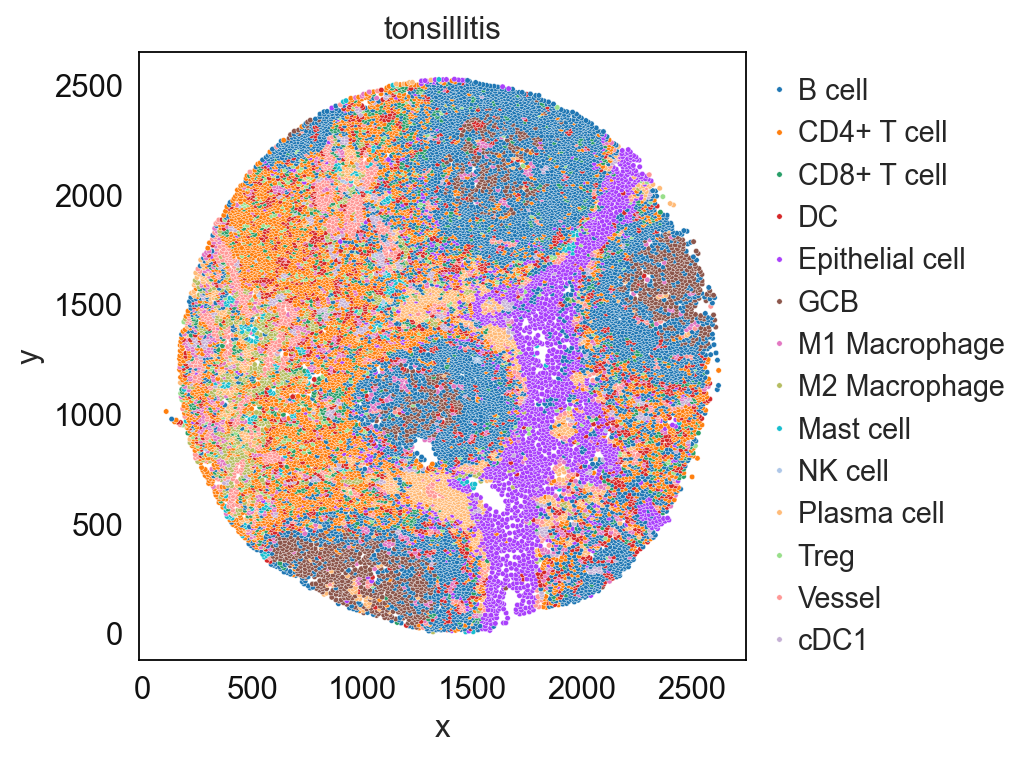

In [25]:
sp.pl.catplot(
    adata_val, color = "svm_pred", # specify group column name here e.g. celltype_fine)
    unique_region = "condition", # specify unique_regions here
    X='x', Y='y', # specify x and y columns here
    n_columns=1, # adjust the number of columns for plotting here (how many plots do you want in one row?)
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # save figure as pdf
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir=output_dir, # specify output directory here (if savefig=True)
)

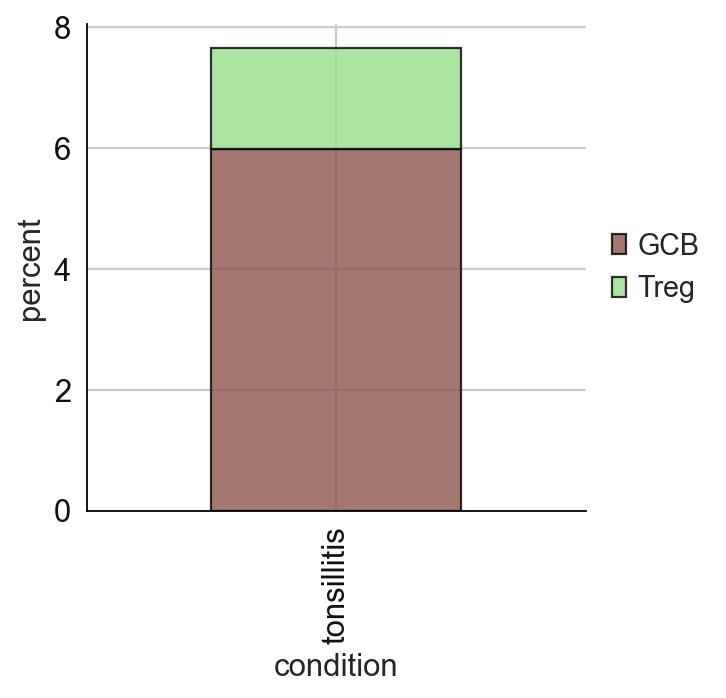

In [26]:
# cell type percentage tab and visualization [much few]
ct_perc_tab, _ = sp.pl.stacked_bar_plot(
    adata = adata_val, # adata object to use 
    color = 'svm_pred', # column containing the categories that are used to fill the bar plot
    grouping = 'condition', # column containing a grouping variable (usually a condition or cell group) 
    cell_list = ['GCB', 'Treg'],  # list of cell types to plot, you can also see the entire cell types adata.obs['celltype_fine'].unique()
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # change it to true if you want to save the figure
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir = output_dir, #output directory for the figure
    norm = False, # if True, then whatever plotted will be scaled to sum of 1
    fig_sizing=(4,4)
)

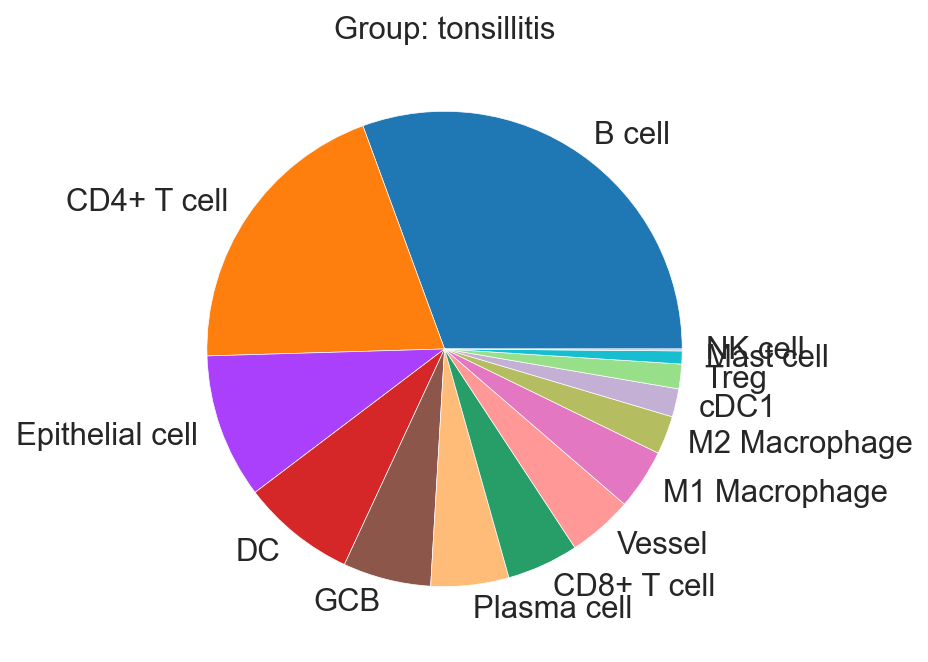

In [29]:
sp.pl.create_pie_charts(
    adata_val,
    color = "svm_pred", 
    grouping = "condition", 
    show_percentages=False,
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # change it to true if you want to save the figure
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir = output_dir #output directory for the figure
)